In [1]:
import sys
sys.path.insert(0, "../")
import scanpy as sc
from model.embedding import embed
import numpy as np

In [3]:
model_dir = "../assets/"
adata_path = "../data/NB.bone.Met_preprocessed.h5ad" # INSERT the path to your anndata object here

# 1. Load the full AnnData object
print(f"Loading full AnnData object from: {adata_path}")
adata_full = sc.read_h5ad(adata_path)
print(f"Successfully loaded. Original shape: {adata_full.shape}")

# --- Subsampling Step ---
fraction_to_keep = 0.05
# For reproducibility of the random sampling
random_seed = 42
np.random.seed(random_seed)
n_obs_original = adata_full.n_obs
n_obs_to_keep = int(n_obs_original * fraction_to_keep)
print(f"Original number of observations: {n_obs_original}")
print(f"Target number of observations to keep ({(fraction_to_keep*100):.1f}%): {n_obs_to_keep}")
keep_indices = np.random.choice(n_obs_original, size=n_obs_to_keep, replace=False)
keep_indices.sort()

adata = adata_full[keep_indices, :].copy()
print(f"Created subset. New shape: {adata.shape}")
#  Optional: release memory used by the full object if it's very large
# import gc
# del adata_full
# gc.collect()
# print("Released memory from full AnnData object.")

# 6. Define keys for subsequent steps (using the subsetted 'adata')
batch_key = "sample" # The batch identity is used for highly variable gene selection
bio_key = "subtype"  # Biological condition key for later visualization

print(f"\nUsing subsetted AnnData object with keys: batch_key='{batch_key}', bio_key='{bio_key}'")
print(adata)

Loading full AnnData object from: ../data/NB.bone.Met_preprocessed.h5ad
Successfully loaded. Original shape: (36763, 25139)
Original number of observations: 36763
Target number of observations to keep (5.0%): 1838
Created subset. New shape: (1838, 25139)

Using subsetted AnnData object with keys: batch_key='sample', bio_key='subtype'
AnnData object with n_obs × n_vars = 1838 × 25139
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'


In [5]:
embed_adata = embed(
    adata_or_file=adata,
    model_dir=model_dir,
    batch_key=batch_key,
    batch_size=64,
)


/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/notebooks/../model/embedding.py:66: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["genes"] = adata.var.index
/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/.venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Embedding cells:   0%|          | 0/29 [00:00<?, ?it/s]/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/.venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors i

In [13]:
print(embed_adata)
sc.pp.neighbors(embed_adata, use_rep="CancerGPT")
sc.tl.umap(embed_adata)
sc.tl.leiden(adata, flavor='igraph', n_iterations=2)
for feature in ["cell1", "cell2", "fraction", "sample"]:
    sc.pl.umap(adata, color=feature, show=False, save=f"_harmony_{feature}.png")

AnnData object with n_obs × n_vars = 1838 × 1199
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden', 'GMM_entropy', 'GMM_cluster'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std', 'genes', 'id_in_vocab', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'leiden', 'neighbors', 'pca', 'umap', 'hvg', 'GMM_cluster_colors'
    obsm: 'X_pca', 'X_umap', 'CancerGPT', 'GMM_probabilities'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'


/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


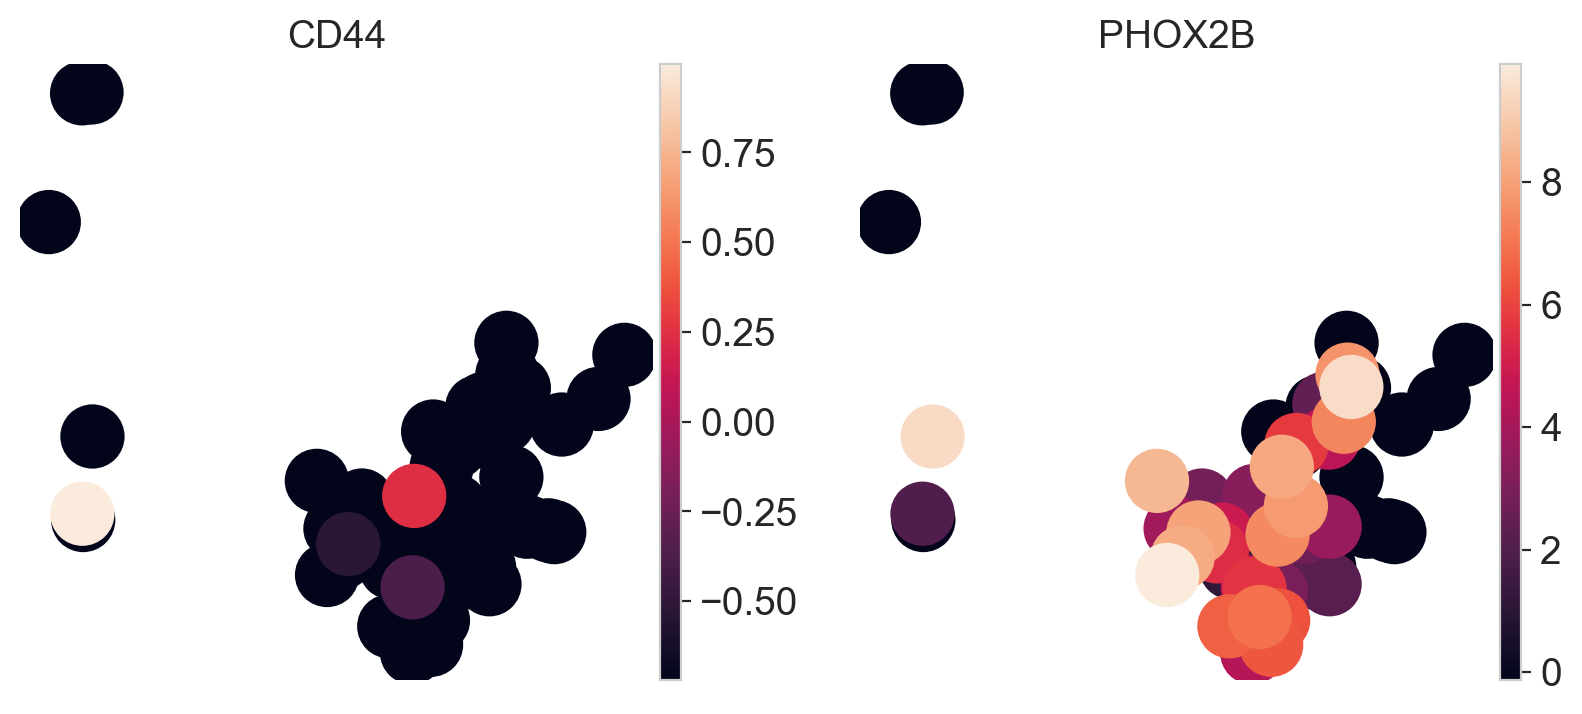

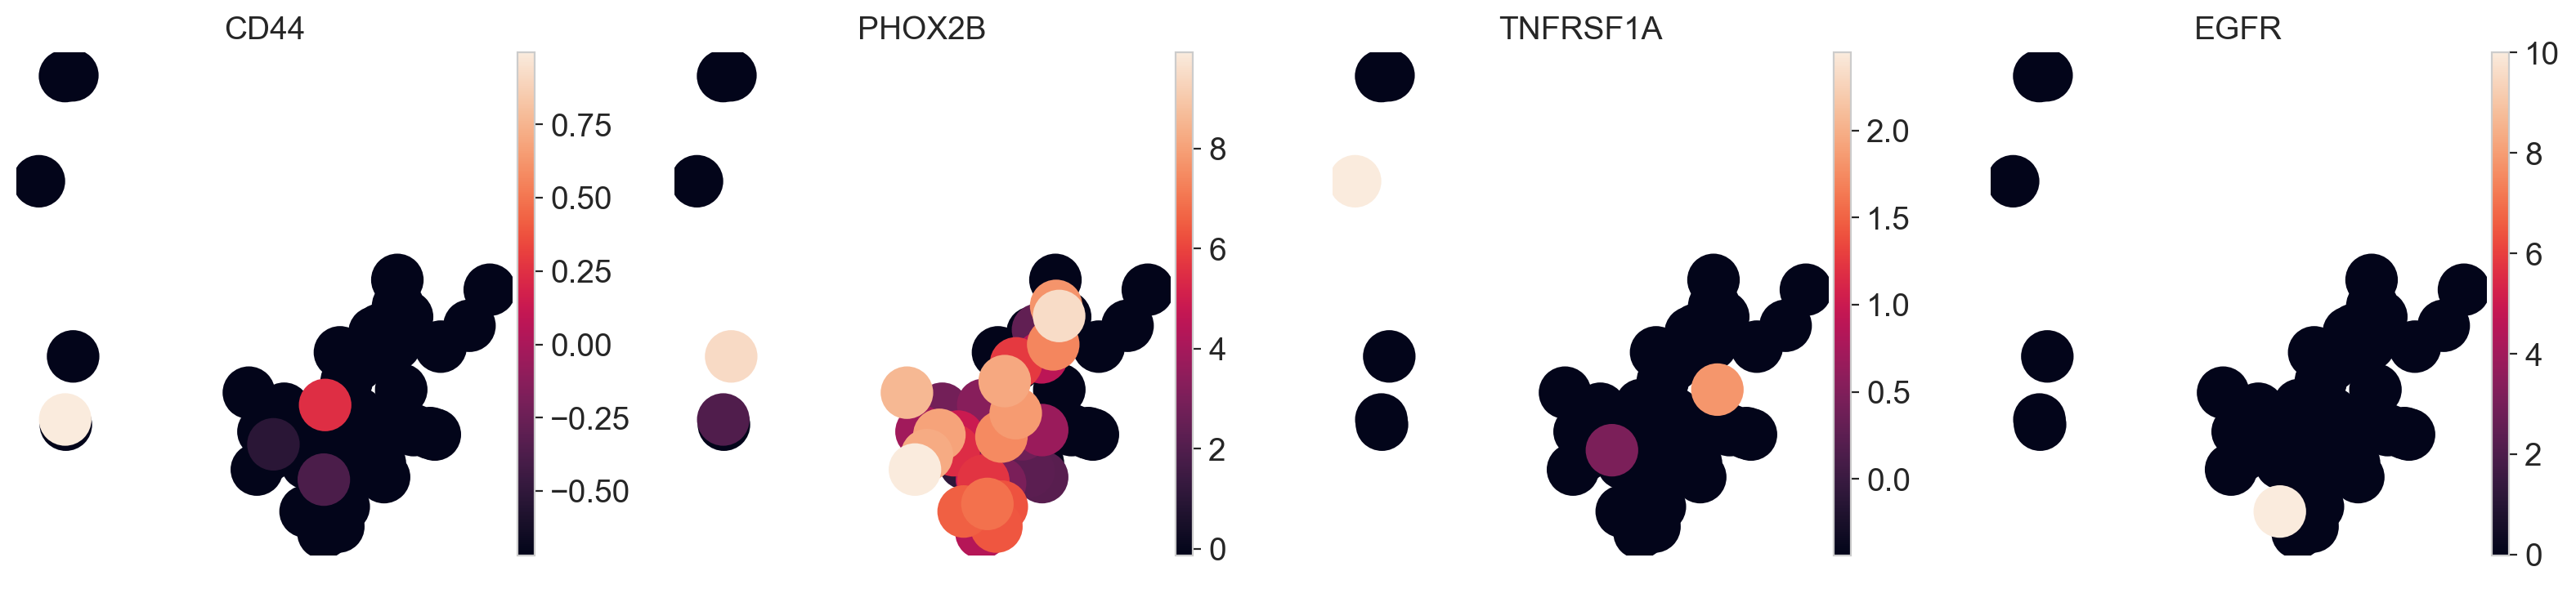

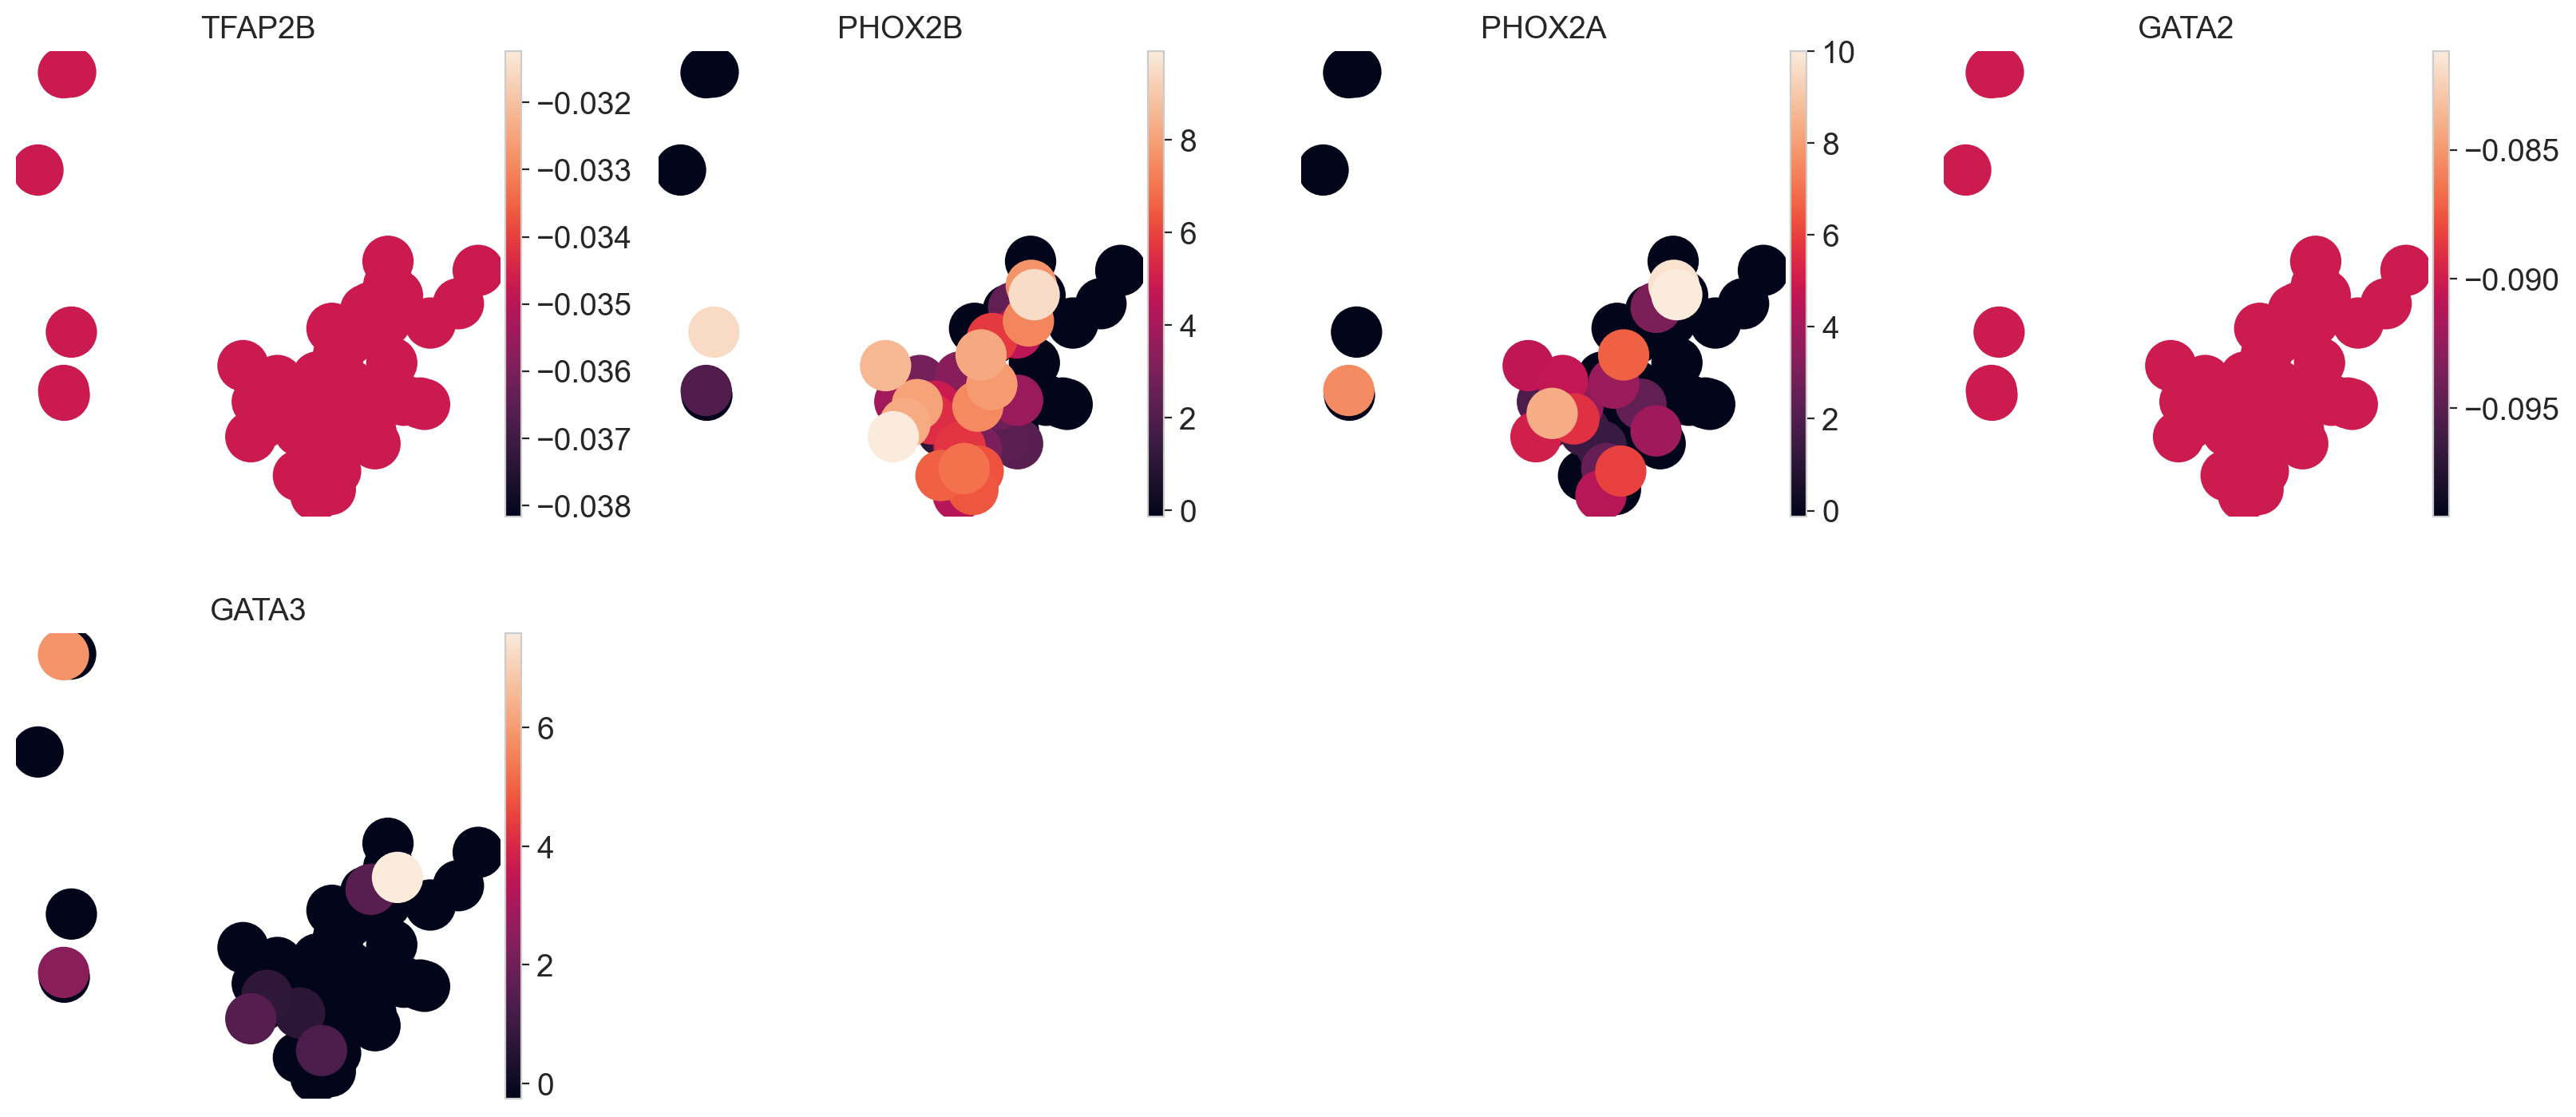

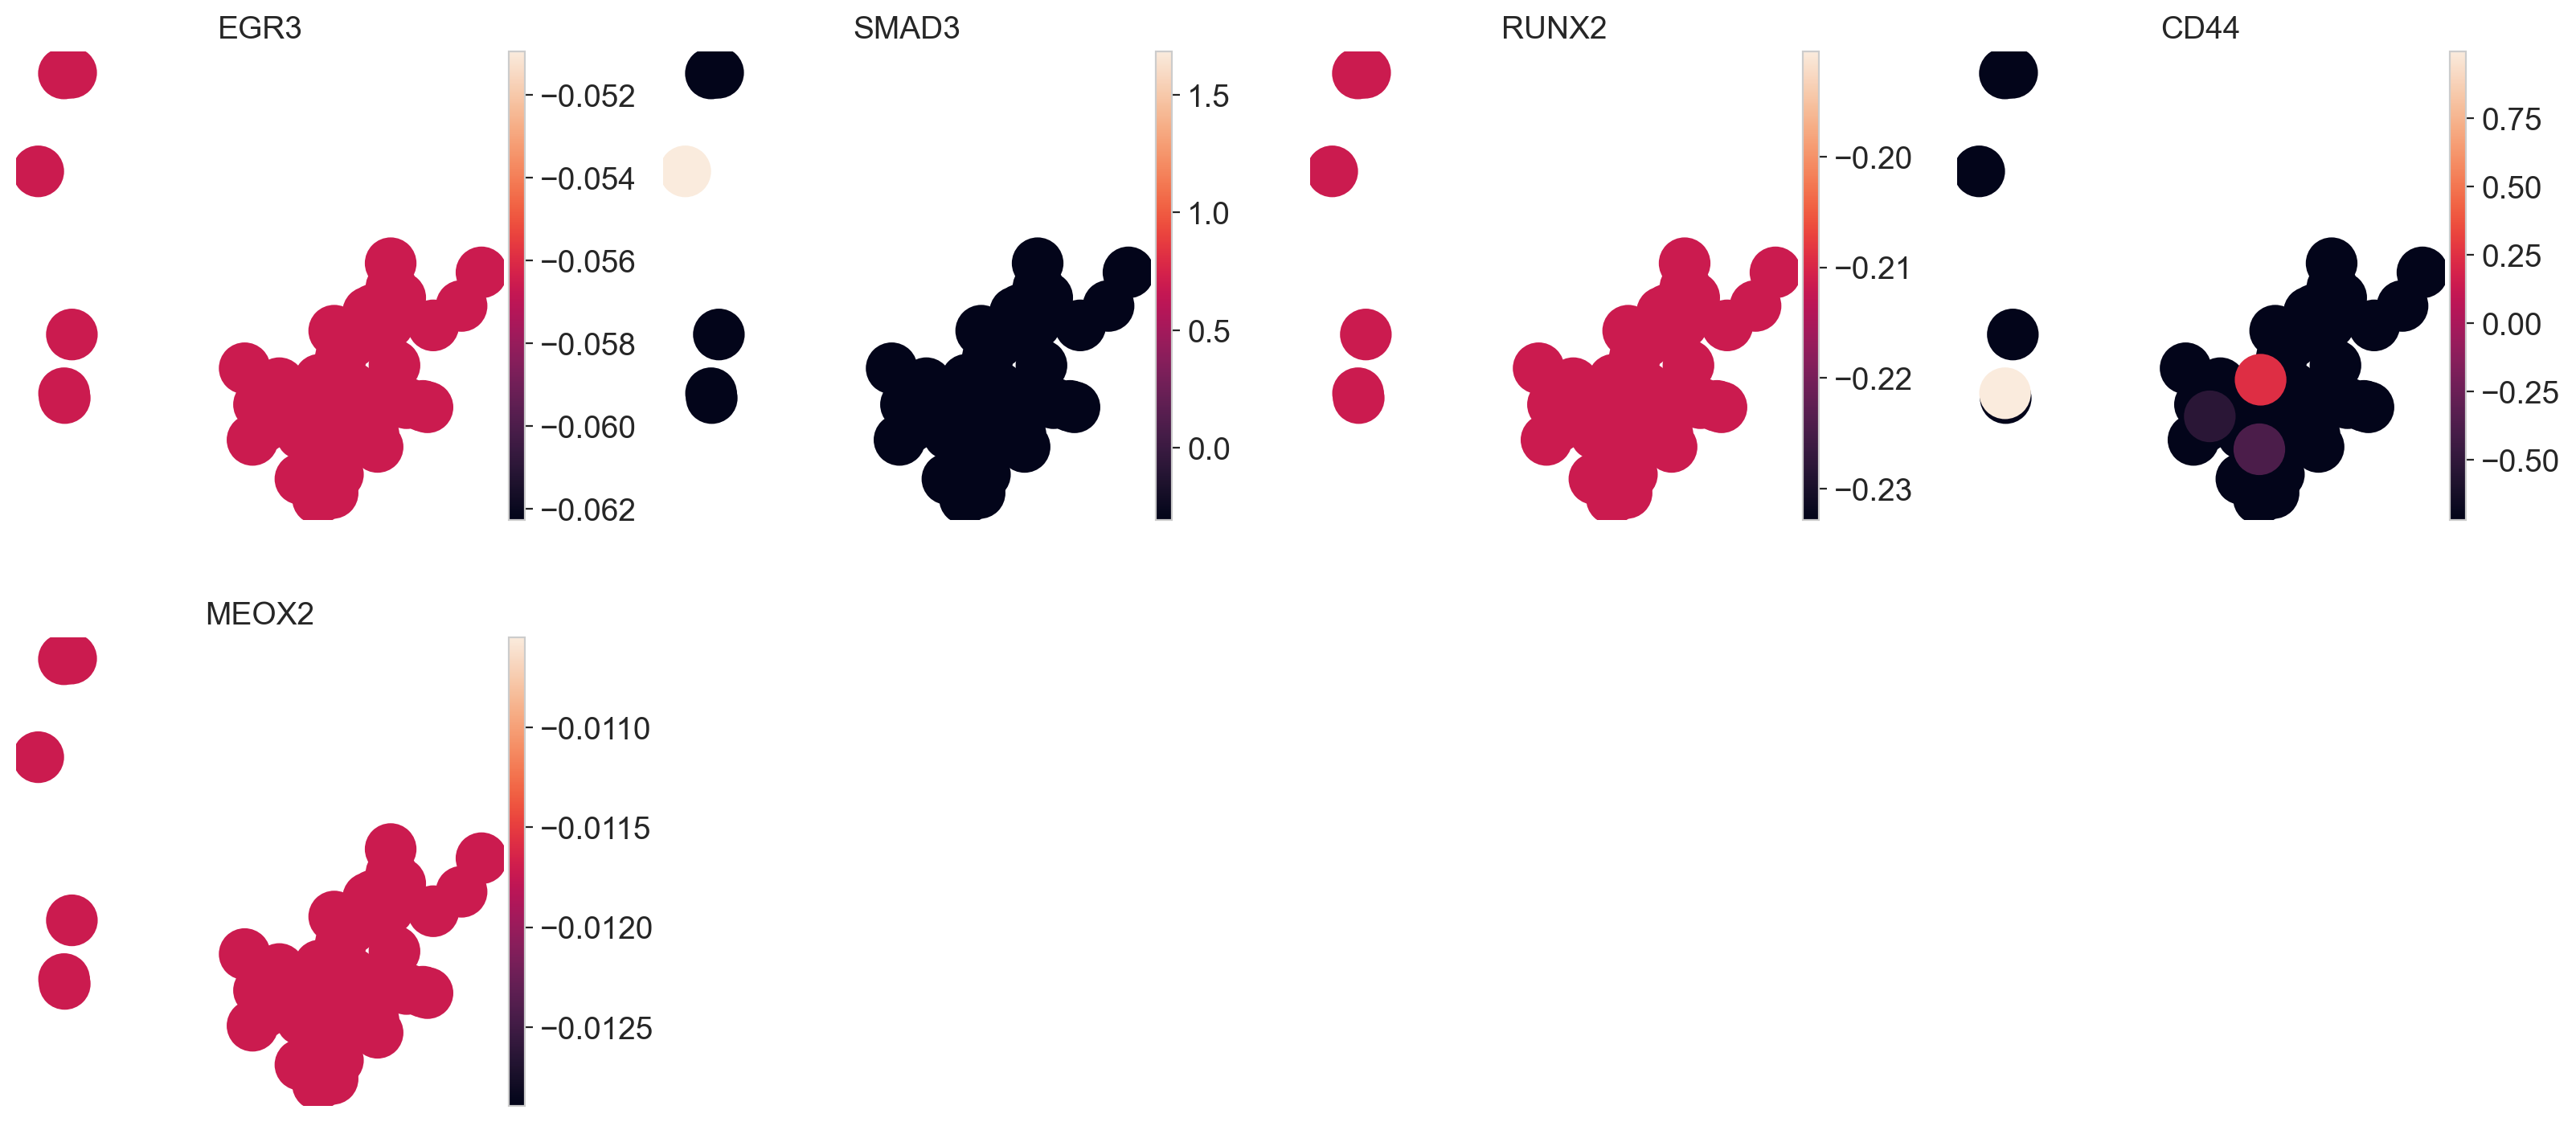

In [14]:
### Check the NOR and ADR signatures in the tumor cells ###

# 1) Subset the AnnData to only include Tumor cells
tumor_adata = adata[adata.obs["cell2"] == "Tumor"].copy()

# 2) Plot the expression of your genes of interest (e.g. "GeneA", "GeneB")
sc.pl.umap(tumor_adata, color=["CD44", "PHOX2B"])

# 3) Plot the expression of your genes of interest (e.g. "GeneA", "GeneB")

## PHOX2B ADR population
## CD44 MES
## TNFRSF1A AND EGFR Bridge to MES

sc.pl.umap(tumor_adata, color=["CD44", "PHOX2B", "TNFRSF1A", "EGFR"])

## NOR genes from https://www.nature.com/articles/s41467-023-38239-5/figures/4
sc.pl.umap(tumor_adata, color=["TFAP2B", "PHOX2B", "PHOX2A", "GATA2", "GATA3"])


## MES genes from https://www.nature.com/articles/s41467-023-38239-5/figures/4

sc.pl.umap(tumor_adata, color=["EGR3", "SMAD3", "RUNX2", "CD44", "MEOX2"])

Fitting GMM with 5 components...
Calculating entropy...
Added 'GMM_probabilities' to embed_adata.obsm
Added 'GMM_entropy' to embed_adata.obs
Added 'GMM_cluster' (dominant cluster) to embed_adata.obs

Done with GMM and entropy calculation.

--- Starting Visualization (using embedding: 'X_umap') ---
Plotting dominant GMM clusters on X_umap...


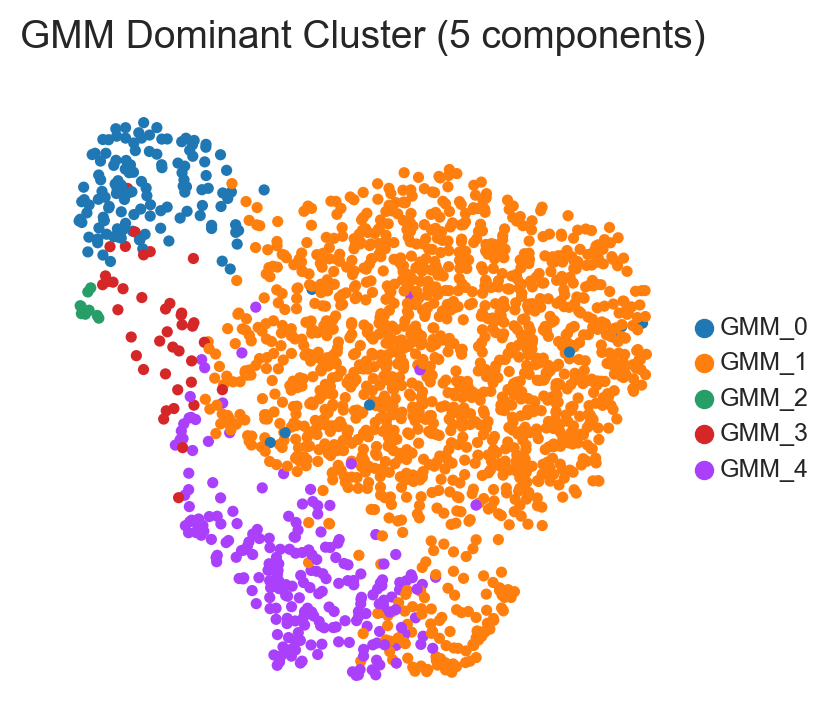

Plotting GMM entropy on X_umap...


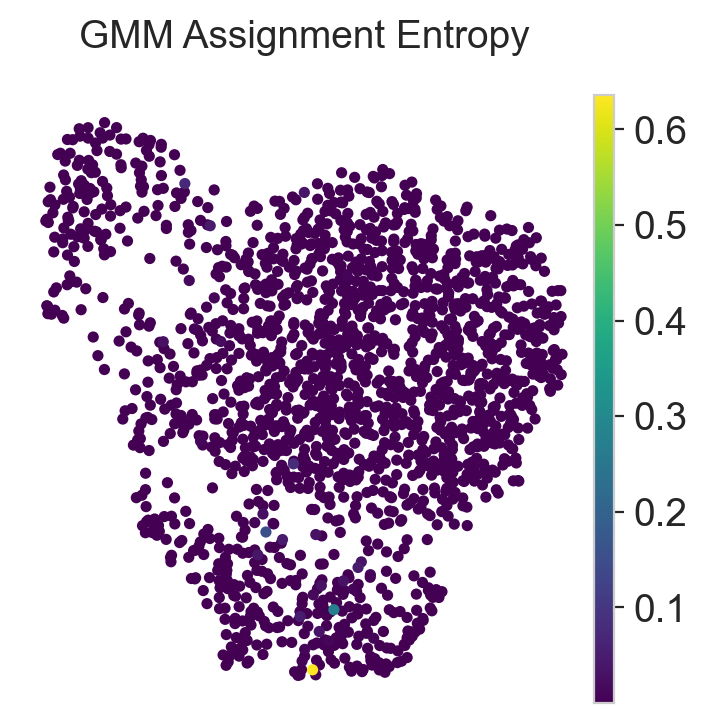

Plotting clusters and entropy side-by-side on X_umap...


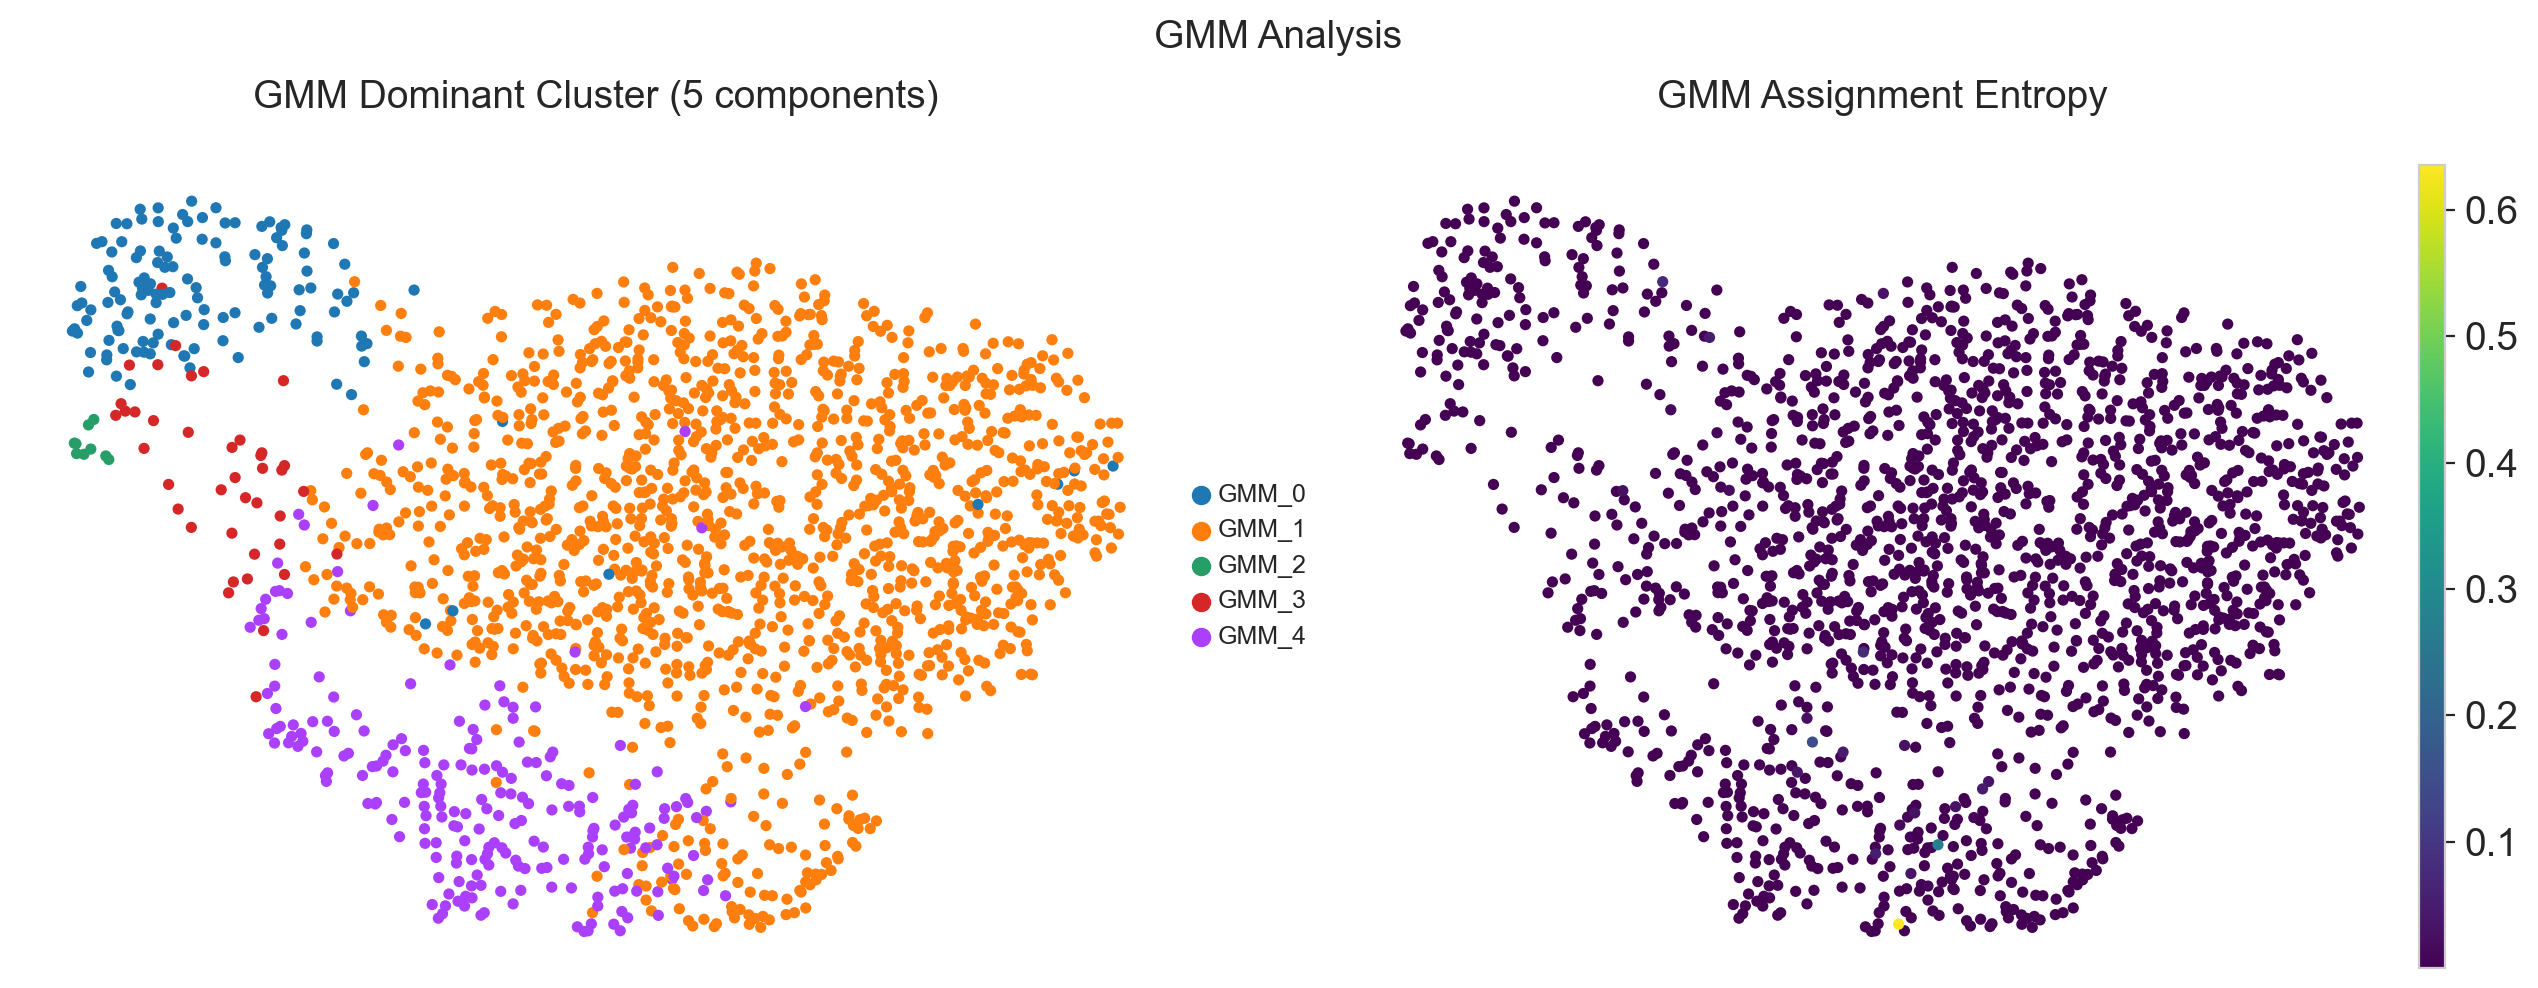


--- Visualization Complete ---


In [16]:
# --- GMM Soft Clustering and Entropy Calculation ---
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt  # <<< ENSURE THIS IS IMPORTED
import seaborn as sns 

n_clusters = 5  # Specify the desired number of clusters (components) - adjust as needed


embeddings = embed_adata.obsm['CancerGPT']
print(f"Fitting GMM with {n_clusters} components...")
gmm = GaussianMixture(n_components=n_clusters,
                      random_state=random_seed,
                      covariance_type='full') # 'full' is default, other options: 'tied', 'diag', 'spherical'
gmm.fit(embeddings)


gmm_probabilities = gmm.predict_proba(embeddings)
print("Calculating entropy...")
# Entropy H(p) = - sum(p_i * log2(p_i))
# Add a small epsilon to avoid log(0)
epsilon = 1e-9
cell_entropy = entropy(gmm_probabilities.T + epsilon, base=2)

# 6. Store results in AnnData object
embed_adata.obsm['GMM_probabilities'] = gmm_probabilities
print("Added 'GMM_probabilities' to embed_adata.obsm")
embed_adata.obs['GMM_entropy'] = cell_entropy
print("Added 'GMM_entropy' to embed_adata.obs")

# --- Add Dominant Cluster Assignment ---
# Find the cluster index with the highest probability for each cell
dominant_cluster = np.argmax(gmm_probabilities, axis=1)
# Store as categorical strings for better plotting with scanpy
embed_adata.obs['GMM_cluster'] = [f'GMM_{c}' for c in dominant_cluster]
embed_adata.obs['GMM_cluster'] = embed_adata.obs['GMM_cluster'].astype('category')
print("Added 'GMM_cluster' (dominant cluster) to embed_adata.obs")

print("\nDone with GMM and entropy calculation.")

embedding_key = 'X_umap'
# --- Visualization ---
print(f"\n--- Starting Visualization (using embedding: '{embedding_key}') ---")

# Configure plot settings (optional, but recommended)
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)
sns.set_style("whitegrid") # Or "white", "ticks", etc.

# --- Titles ---
title_cluster = f'GMM Dominant Cluster ({n_clusters} components)'
title_entropy = 'GMM Assignment Entropy'
title_y_position = 1.05 # Adjust this value to move title further up (e.g., 1.05) or down (e.g., 1.01)

# 1. Visualize Dominant GMM Clusters
print(f"Plotting dominant GMM clusters on {embedding_key}...")
fig1, ax1 = plt.subplots()
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_cluster',
                # --- MODIFICATION START ---
                title=None, # Remove title from scanpy call
                # --- MODIFICATION END ---
                legend_loc='right margin',
                legend_fontsize=9,
                ax=ax1,
                show=False)

# Set title manually using matplotlib with adjusted vertical position
ax1.set_title(title_cluster, y=title_y_position)
# plt.savefig(f'gmm_clusters_{embedding_key}.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()

# 2. Visualize GMM Assignment Entropy
print(f"Plotting GMM entropy on {embedding_key}...")
fig2, ax2 = plt.subplots()
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_entropy',
                # --- MODIFICATION START ---
                title=None, # Remove title from scanpy call
                # --- MODIFICATION END ---
                cmap='viridis',
                colorbar_loc='right',
                ax=ax2,
                show=False)
# Set title manually using matplotlib with adjusted vertical position
ax2.set_title(title_entropy, y=title_y_position)
# plt.savefig(f'gmm_entropy_{embedding_key}.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()

# 3. Visualize Both Side-by-Side (Optional)
print(f"Plotting clusters and entropy side-by-side on {embedding_key}...")
fig3, axes = plt.subplots(1, 2, figsize=(13, 5))

# Plot Clusters on the left
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_cluster',
                 # --- MODIFICATION START ---
                title=None, # Remove title from scanpy call
                # --- MODIFICATION END ---
                legend_loc='right margin',
                legend_fontsize=9,
                ax=axes[0],
                show=False)
# --- MODIFICATION START ---
axes[0].set_title(title_cluster, y=title_y_position) # Set title manually
# --- MODIFICATION END ---
axes[0].set_xlabel(f"{embedding_key.split('_')[-1].upper()} 1")
axes[0].set_ylabel(f"{embedding_key.split('_')[-1].upper()} 2")

# Plot Entropy on the right
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_entropy',
                 # --- MODIFICATION START ---
                title=None, # Remove title from scanpy call
                # --- MODIFICATION END ---
                cmap='viridis',
                colorbar_loc='right',
                ax=axes[1],
                show=False)

axes[1].set_title(title_entropy, y=title_y_position) # Set title manually
axes[1].set_xlabel(f"{embedding_key.split('_')[-1].upper()} 1")
axes[1].set_ylabel(f"{embedding_key.split('_')[-1].upper()} 2")


# Use tight_layout *after* setting titles
plt.tight_layout(rect=[0, 0, 1, 0.97]) # Add rect to potentially leave space for suptitle if needed, adjust top value (0.97) if titles still overlap
fig3.suptitle("GMM Analysis", fontsize=14, y=0.99) # Example suptitle

# plt.savefig(f'gmm_clusters_entropy_{embedding_key}_combined.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()

print("\n--- Visualization Complete ---")

Assigning hard GMM clusters...
Added 'GMM_cluster' to embed_adata.obs
Generating UMAP plots for GMM results...


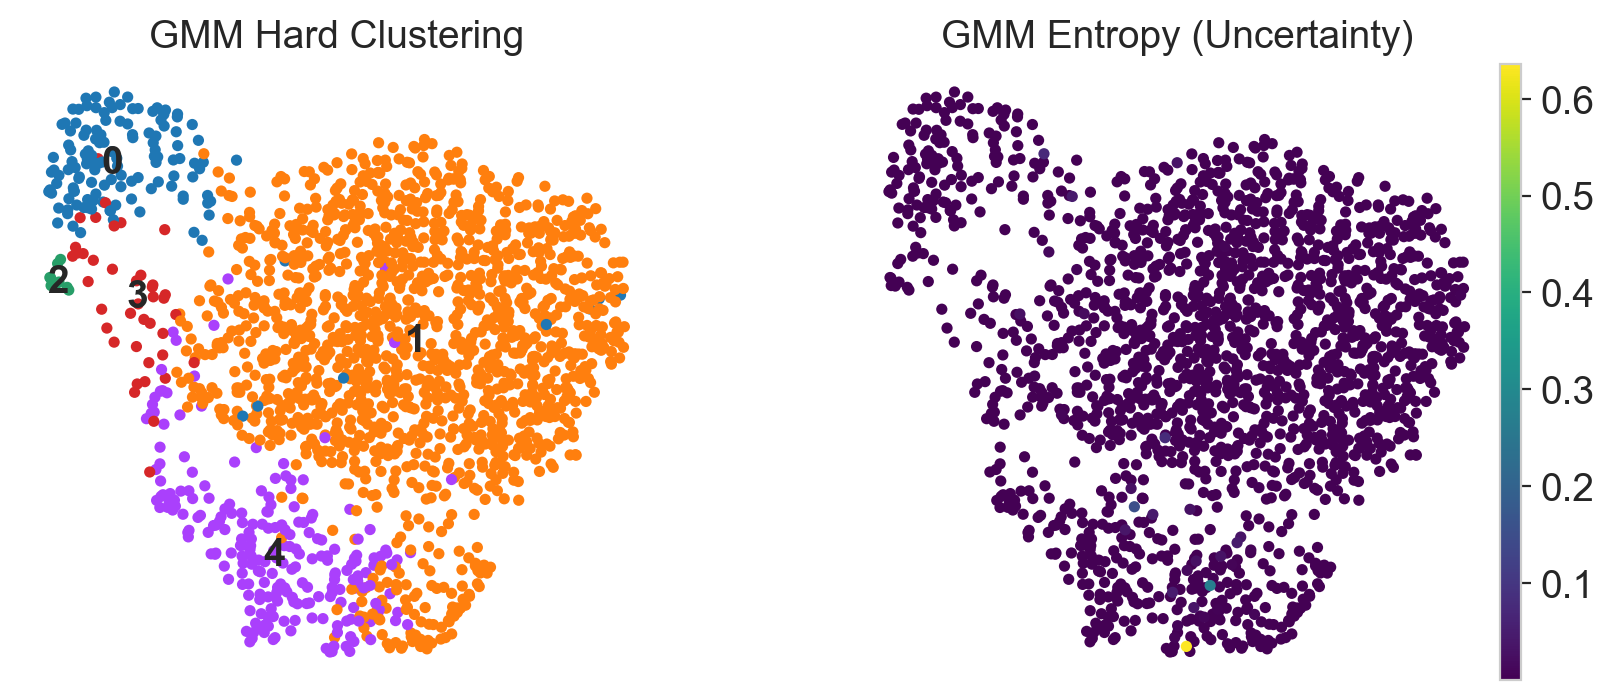


Visualization complete.


In [17]:
# previous code just for error checking

import scanpy as sc
import numpy as np
import pandas as pd # Needed for categorical conversion
import matplotlib.pyplot as plt # Optional, for layout adjustments

# --- Assign Hard Clusters ---
# Get the cluster index with the maximum probability for each cell
print("Assigning hard GMM clusters...")
gmm_hard_clusters = np.argmax(embed_adata.obsm['GMM_probabilities'], axis=1)

# Store these hard assignments in .obs for easy plotting
# Convert to categorical for distinct colors in scanpy plots
embed_adata.obs['GMM_cluster'] = pd.Categorical(gmm_hard_clusters)
print("Added 'GMM_cluster' to embed_adata.obs")

# --- Visualize on UMAP ---
print("Generating UMAP plots for GMM results...")

# Check if UMAP coordinates exist, calculate if not (should exist from previous step)
if 'X_umap' not in embed_adata.obsm:
    print("Calculating UMAP coordinates (should have been done earlier)...")
    sc.pp.neighbors(embed_adata, use_rep='CancerGPT')
    sc.tl.umap(embed_adata)

# Plot side-by-side: Hard clusters and Entropy
sc.pl.umap(
    embed_adata,
    color=['GMM_cluster', 'GMM_entropy'], # Keys from .obs to color by
    title=['GMM Hard Clustering', 'GMM Entropy (Uncertainty)'], # Titles for each plot
    frameon=False,
    # GMM_cluster is categorical, scanpy often picks a good default palette.
    # GMM_entropy is continuous, use a sequential colormap like viridis.
    cmap='viridis', # Applied to continuous data ('GMM_entropy')
    legend_loc='on data', # Place legend for 'GMM_cluster' directly on plot areas
    ncols=2 # Arrange the two plots in two columns
)

# plt.show() # Usually not needed in Jupyter notebooks, but uncomment if plots don't appear
print("\nVisualization complete.")